<a href="https://colab.research.google.com/github/nkanungo/EVA6/blob/main/Custom_Resnet_SuperResolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment S9 (Super Convergence)
In this assignment, for training CIFAR-10 dataset, Custom ResNet architecutre, Data Augmentation (Padding, RadnomCrop, Cutout, Horizontal Flip) and One Cycle LR policy are used to train teh model in 24 epochs and achieved 90.51% Test Accuracy . Developed APIs so as to load data, train, test and show results.

Following changes are done:

1. Added Data Augmentations (Albumentatons)

i. Padding (4)

ii. RandomCrop

iii. Cutout

iv. Horizontal Flip

2. Plotted the Cyclic LR over iterations

3. Performed LR Range Test for various maximum LR values for test accuracy in 5 epochs

4. Used One Cycle learning strategey for scheduling learning rates

Got best test accuracy: 90.51%


In [1]:
%matplotlib inline
import autoreload
%load_ext autoreload
%autoreload

In [2]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-56hdp5z2
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-56hdp5z2
  Created wheel for albumentations: filename=albumentations-1.0.1-cp37-none-any.whl size=98544 sha256=a0e417ac8e0027214b6f978e45feccee01fd1cafb7715648b33a8b068b8f1d3f
  Stored in directory: /tmp/pip-ephem-wheel-cache-sjy4cr7g/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Mount the google drive

In [3]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Clone the Github Repository

In [4]:
!git clone https://github.com/nkanungo/EVA6.git

Cloning into 'EVA6'...
remote: Enumerating objects: 730, done.
remote: Counting objects: 100% (312/312), done.
remote: Compressing objects: 100% (297/297), done.
remote: Total 730 (delta 184), reused 47 (delta 14), pack-reused 418
Receiving objects: 100% (730/730), 10.52 MiB | 35.57 MiB/s, done.
Resolving deltas: 100% (385/385), done.


## Copy all the API python files from the google drive to local folder

Follwing python files are imported from google drive. Purpsoe of these files are as below:

model.py - Defines the model class Net
train_test.py- API for training and testing
accuracy_utils - API foro getting test accuracy and per class accuracy
data_loader.py - API for loading train and test data
data_transform.py - API for transforming and normalizing data
plot_metrics.py - API for plotting metrics

In [5]:
!cp -rf '/content/EVA6/Custom_Resnet_Super_Convergence/data_loaders' .
!cp -rf '/content/EVA6/Custom_Resnet_Super_Convergence/data_transformations' .
!cp -rf '/content/EVA6/Custom_Resnet_Super_Convergence/models' .
!cp -rf '/content/EVA6/Custom_Resnet_Super_Convergence/utils' .

## Import all the libraries

In [6]:
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from data_transformations.data_transform_cifar10_custom_resnet import get_train_transform, get_test_transform
from data_loaders.cifar10_data_loader import get_train_loader, get_test_loader, get_classes
from models.CustomResNet import CustomResNet
from utils.train_test_utils import train,test
from utils.accuracy_utils import get_test_accuracy,get_accuracy_per_class
from utils.plot_metrics_utils import plot_loss_accuracy,plot_accuracy,plot_max_lr_vs_test_accuracy

from utils.misclassified_image_utils import  display_misclassfied_ciphar10_images
from utils.gradcamkz_util import GRADCAM, PLOT,PLOTGRADCAM
from utils.gradcamkz_util import process_for_grad_cam
from utils.cyclic_lr_util import triangle_lr_plot,custom_one_cycle_lr, max_lr_finder_schedule

## PLOT CYCLIC LR

In this step, cyclic LR  is plotted over iterations. In this example, minimum LR =0.01, maximum LR =0.4, Step size = 10, Number of Iterations = 100 are used

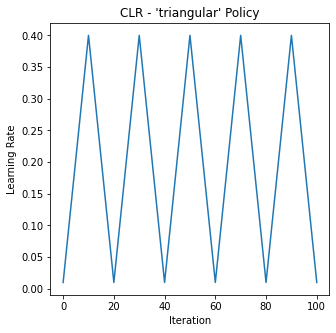

In [7]:
triangle_lr_plot(0.01, 0.4, 10, 100)


Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





 ## 1. Loading and normalizing CIFAR10

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [8]:
from models.main import train_test_loader,imshow, get_model,find_lr_value, train_model

In [9]:
BATCH_SIZE=512
trainloader, testloader, classes,transform_train,transform_test = train_test_loader(BATCH_SIZE,get_train_transform, get_test_transform,get_train_loader, get_test_loader, get_classes)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:690: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,



Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


## Visualizing some of the images in train dataset



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  cat  bird truck  bird


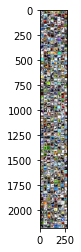

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

I have defined the custom ResNet18 model 



In [11]:
!pip install torchsummary
from torchsummary import summary

model = get_model(CustomResNet)
print(model)
summary(model, input_size=(3, 32, 32))

CustomResNet(
  (conv): ConvBNBlock(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_out): Dropout2d(p=0.0, inplace=False)
  )
  (layer1): ResBlock(
    (transition_block): TransitionBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_out): Dropout2d(p=0.0, inplace=False)
    )
    (conv_block1): ConvBNBlock(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_out): Dropout2d(p=0.0, inplace=False)
    )
    (conv_block2): ConvBNBlock(
      (conv): Conv2d(128, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/content/models/CustomResNet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## LR Range Test

In this step, a ranges of maximum Learning Rate values are searched for which gives good test accuracy in 5 epochs.

In [12]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import os

model = get_model(CustomResNet)
PATH_BASE_MODEL = 'base_weights_lr_range_test.pth'
torch.save(model.state_dict(), PATH_BASE_MODEL)
EPOCHS_TO_TRY = 5
max_lr_list = [0.001, 0.004, 0.008, 0.01,0.04,0.08,0.1,0.4,0.8,1,2,4]
test_accuracy_list = []
find_lr_value(model,EPOCHS_TO_TRY,max_lr_list,test_accuracy_list,PATH_BASE_MODEL,max_lr_finder_schedule,BATCH_SIZE,train,test,trainloader,testloader)

  0%|          | 0/98 [00:00<?, ?it/s]

MAX LR: 0.001  EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/models/CustomResNet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=3.1832995414733887 Batch_id=97 Accuracy=9.82: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.2823, Accuracy: 960/10000 (9.60%)

MAX LR: 0.001  EPOCH: 2


Loss=3.2904913425445557 Batch_id=97 Accuracy=9.90: 100%|██████████| 98/98 [00:23<00:00,  4.18it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.2645, Accuracy: 960/10000 (9.60%)

MAX LR: 0.001  EPOCH: 3


Loss=3.0946898460388184 Batch_id=97 Accuracy=9.72: 100%|██████████| 98/98 [00:23<00:00,  4.09it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.2229, Accuracy: 957/10000 (9.57%)

MAX LR: 0.001  EPOCH: 4


Loss=3.1105313301086426 Batch_id=97 Accuracy=9.88: 100%|██████████| 98/98 [00:24<00:00,  4.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.1979, Accuracy: 957/10000 (9.57%)

MAX LR: 0.001  EPOCH: 5


Loss=3.1944165229797363 Batch_id=97 Accuracy=9.80: 100%|██████████| 98/98 [00:24<00:00,  3.95it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.1499, Accuracy: 947/10000 (9.47%)

 For Max LR:  0.001  Test Accuracy:  9.47
MAX LR: 0.004  EPOCH: 1


Loss=3.1669366359710693 Batch_id=97 Accuracy=9.78: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.1490, Accuracy: 953/10000 (9.53%)

MAX LR: 0.004  EPOCH: 2


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.9607, Accuracy: 957/10000 (9.57%)

MAX LR: 0.004  EPOCH: 3


Loss=2.816371440887451 Batch_id=97 Accuracy=10.21: 100%|██████████| 98/98 [00:25<00:00,  3.92it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.7916, Accuracy: 1026/10000 (10.26%)

MAX LR: 0.004  EPOCH: 4


Loss=2.6581857204437256 Batch_id=97 Accuracy=10.79: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.6597, Accuracy: 1079/10000 (10.79%)

MAX LR: 0.004  EPOCH: 5


Loss=2.510591506958008 Batch_id=97 Accuracy=11.32: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.5441, Accuracy: 1111/10000 (11.11%)

 For Max LR:  0.004  Test Accuracy:  11.11
MAX LR: 0.008  EPOCH: 1


Loss=2.9334347248077393 Batch_id=97 Accuracy=9.97: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.8847, Accuracy: 977/10000 (9.77%)

MAX LR: 0.008  EPOCH: 2


Loss=2.546921730041504 Batch_id=97 Accuracy=10.95: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.6040, Accuracy: 1100/10000 (11.00%)

MAX LR: 0.008  EPOCH: 3


Loss=2.4835782051086426 Batch_id=97 Accuracy=11.88: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.4015, Accuracy: 1269/10000 (12.69%)

MAX LR: 0.008  EPOCH: 4


Loss=2.2560977935791016 Batch_id=97 Accuracy=14.39: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.2565, Accuracy: 1669/10000 (16.69%)

MAX LR: 0.008  EPOCH: 5


Loss=2.210271120071411 Batch_id=97 Accuracy=18.23: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1863, Accuracy: 2061/10000 (20.61%)

 For Max LR:  0.008  Test Accuracy:  20.61
MAX LR: 0.01  EPOCH: 1


Loss=2.781132936477661 Batch_id=97 Accuracy=10.02: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.7792, Accuracy: 1029/10000 (10.29%)

MAX LR: 0.01  EPOCH: 2


Loss=2.5150692462921143 Batch_id=97 Accuracy=11.09: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.4767, Accuracy: 1181/10000 (11.81%)

MAX LR: 0.01  EPOCH: 3


Loss=2.2382450103759766 Batch_id=97 Accuracy=13.33: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.2697, Accuracy: 1603/10000 (16.03%)

MAX LR: 0.01  EPOCH: 4


Loss=2.214838981628418 Batch_id=97 Accuracy=18.17: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1792, Accuracy: 2088/10000 (20.88%)

MAX LR: 0.01  EPOCH: 5


Loss=2.143583297729492 Batch_id=97 Accuracy=21.25: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1132, Accuracy: 2378/10000 (23.78%)

 For Max LR:  0.01  Test Accuracy:  23.78
MAX LR: 0.04  EPOCH: 1


Loss=2.217585325241089 Batch_id=97 Accuracy=15.49: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1037, Accuracy: 2391/10000 (23.91%)

MAX LR: 0.04  EPOCH: 2


Loss=1.9324473142623901 Batch_id=97 Accuracy=25.76: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8996, Accuracy: 3063/10000 (30.63%)

MAX LR: 0.04  EPOCH: 3


Loss=1.7868516445159912 Batch_id=97 Accuracy=31.61: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7445, Accuracy: 3695/10000 (36.95%)

MAX LR: 0.04  EPOCH: 4


Loss=1.739598035812378 Batch_id=97 Accuracy=36.39: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6150, Accuracy: 4155/10000 (41.55%)

MAX LR: 0.04  EPOCH: 5


Loss=1.5342859029769897 Batch_id=97 Accuracy=40.36: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5189, Accuracy: 4516/10000 (45.16%)

 For Max LR:  0.04  Test Accuracy:  45.16
MAX LR: 0.08  EPOCH: 1


Loss=1.9018076658248901 Batch_id=97 Accuracy=22.04: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.8464, Accuracy: 3286/10000 (32.86%)

MAX LR: 0.08  EPOCH: 2


Loss=1.6495184898376465 Batch_id=97 Accuracy=35.11: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5870, Accuracy: 4247/10000 (42.47%)

MAX LR: 0.08  EPOCH: 3


Loss=1.5069035291671753 Batch_id=97 Accuracy=42.62: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4413, Accuracy: 4818/10000 (48.18%)

MAX LR: 0.08  EPOCH: 4


Loss=1.3673042058944702 Batch_id=97 Accuracy=48.10: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3016, Accuracy: 5318/10000 (53.18%)

MAX LR: 0.08  EPOCH: 5


Loss=1.2138252258300781 Batch_id=97 Accuracy=52.57: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2441, Accuracy: 5577/10000 (55.77%)

 For Max LR:  0.08  Test Accuracy:  55.77
MAX LR: 0.1  EPOCH: 1


Loss=1.817567229270935 Batch_id=97 Accuracy=24.51: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7528, Accuracy: 3701/10000 (37.01%)

MAX LR: 0.1  EPOCH: 2


Loss=1.6448169946670532 Batch_id=97 Accuracy=38.66: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4868, Accuracy: 4526/10000 (45.26%)

MAX LR: 0.1  EPOCH: 3


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3483, Accuracy: 5180/10000 (51.80%)

MAX LR: 0.1  EPOCH: 4


Loss=1.255818247795105 Batch_id=97 Accuracy=52.22: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2337, Accuracy: 5603/10000 (56.03%)

MAX LR: 0.1  EPOCH: 5


Loss=1.1557462215423584 Batch_id=97 Accuracy=56.40: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1684, Accuracy: 5886/10000 (58.86%)

 For Max LR:  0.1  Test Accuracy:  58.86
MAX LR: 0.4  EPOCH: 1


Loss=1.4387998580932617 Batch_id=97 Accuracy=37.54: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4639, Accuracy: 4944/10000 (49.44%)

MAX LR: 0.4  EPOCH: 2


Loss=1.2616583108901978 Batch_id=97 Accuracy=55.80: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2199, Accuracy: 5888/10000 (58.88%)

MAX LR: 0.4  EPOCH: 3


Loss=1.0072298049926758 Batch_id=97 Accuracy=64.06: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0687, Accuracy: 6450/10000 (64.50%)

MAX LR: 0.4  EPOCH: 4


Loss=0.7963970899581909 Batch_id=97 Accuracy=69.86: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7968, Accuracy: 7258/10000 (72.58%)

MAX LR: 0.4  EPOCH: 5


Loss=0.6171966195106506 Batch_id=97 Accuracy=73.67: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0465, Accuracy: 6719/10000 (67.19%)

 For Max LR:  0.4  Test Accuracy:  67.19
MAX LR: 0.8  EPOCH: 1


Loss=1.3337674140930176 Batch_id=97 Accuracy=36.18: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6902, Accuracy: 4676/10000 (46.76%)

MAX LR: 0.8  EPOCH: 2


Loss=1.1809256076812744 Batch_id=97 Accuracy=55.15: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1031, Accuracy: 6366/10000 (63.66%)

MAX LR: 0.8  EPOCH: 3


Loss=0.9920841455459595 Batch_id=97 Accuracy=64.11: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1469, Accuracy: 6395/10000 (63.95%)

MAX LR: 0.8  EPOCH: 4


Loss=0.820938766002655 Batch_id=97 Accuracy=68.54: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1981, Accuracy: 6618/10000 (66.18%)

MAX LR: 0.8  EPOCH: 5


Loss=0.9384110569953918 Batch_id=97 Accuracy=71.67: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0516, Accuracy: 6971/10000 (69.71%)

 For Max LR:  0.8  Test Accuracy:  69.71
MAX LR: 1  EPOCH: 1


Loss=2.3513715267181396 Batch_id=97 Accuracy=19.58: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 4.8259, Accuracy: 2197/10000 (21.97%)

MAX LR: 1  EPOCH: 2


Loss=1.8523476123809814 Batch_id=97 Accuracy=31.57: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.1198, Accuracy: 3595/10000 (35.95%)

MAX LR: 1  EPOCH: 3


Loss=1.5207853317260742 Batch_id=97 Accuracy=39.54: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.2886, Accuracy: 3696/10000 (36.96%)

MAX LR: 1  EPOCH: 4


Loss=2.290271520614624 Batch_id=97 Accuracy=46.96: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6144, Accuracy: 4357/10000 (43.57%)

MAX LR: 1  EPOCH: 5


Loss=1.2218347787857056 Batch_id=97 Accuracy=54.12: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1334, Accuracy: 6172/10000 (61.72%)

 For Max LR:  1  Test Accuracy:  61.72
MAX LR: 2  EPOCH: 1


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 3.1719, Accuracy: 1550/10000 (15.50%)

MAX LR: 2  EPOCH: 2


Loss=2.0130484104156494 Batch_id=97 Accuracy=20.68: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.9879, Accuracy: 2538/10000 (25.38%)

MAX LR: 2  EPOCH: 3


Loss=1.827491044998169 Batch_id=97 Accuracy=29.84: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7082, Accuracy: 3727/10000 (37.27%)

MAX LR: 2  EPOCH: 4


Loss=1.513681411743164 Batch_id=97 Accuracy=38.09: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.6169, Accuracy: 4179/10000 (41.79%)

MAX LR: 2  EPOCH: 5


Loss=1.4279427528381348 Batch_id=97 Accuracy=45.02: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4035, Accuracy: 4922/10000 (49.22%)

 For Max LR:  2  Test Accuracy:  49.22
MAX LR: 4  EPOCH: 1


Loss=2.3127682209014893 Batch_id=97 Accuracy=10.23: 100%|██████████| 98/98 [00:24<00:00,  4.04it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.5676, Accuracy: 1000/10000 (10.00%)

MAX LR: 4  EPOCH: 2


Loss=2.305424213409424 Batch_id=97 Accuracy=10.15: 100%|██████████| 98/98 [00:23<00:00,  4.24it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.3061, Accuracy: 1000/10000 (10.00%)

MAX LR: 4  EPOCH: 3


Loss=2.305454730987549 Batch_id=97 Accuracy=10.05: 100%|██████████| 98/98 [00:22<00:00,  4.27it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.3111, Accuracy: 1000/10000 (10.00%)

MAX LR: 4  EPOCH: 4


Loss=2.3064162731170654 Batch_id=97 Accuracy=9.62: 100%|██████████| 98/98 [00:22<00:00,  4.26it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 2.3084, Accuracy: 1000/10000 (10.00%)

MAX LR: 4  EPOCH: 5


Loss=2.3106179237365723 Batch_id=97 Accuracy=10.11: 100%|██████████| 98/98 [00:22<00:00,  4.28it/s]



Test set: Average loss: 2.3172, Accuracy: 1000/10000 (10.00%)

 For Max LR:  4  Test Accuracy:  10.0


## Plot Maximum Learning Rate vs Test Accuracy (5 epochs)

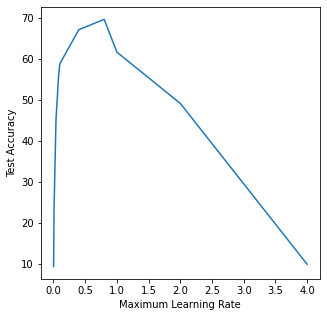

In [13]:
plot_max_lr_vs_test_accuracy(max_lr_list,test_accuracy_list)

From the LR Range Test found that maximum LR value of 0.4 gives Test Accuracy of 72.58 but maximum LR value of 0.8 gives Test accuracy of 69.71 in 5 epochs. 

However maximum LR vlaue of 0.8, there is a steady increase of test accuracy over epochs compared to maximum LR value of 0.4 ,where there is a sudden increase. So decided to use maximum LR value of 0.8

## 3. Define a Loss function and optimizer and train the model

Used Classification Cross-Entropy loss and SGD with momentum 0.9.

## 4. Train the model

 24 epochs are used to train the model. Used One Cycle LR policy for changing Learning Rates with maximum learning rate of 0.8. 

In [14]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [15]:
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
import os

# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")      
model = get_model(CustomResNet)
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
EPOCHS = 24

one_cyle_lr = custom_one_cycle_lr(no_of_images=50176, batch_size=BATCH_SIZE, base_lr=0.08, max_lr=0.8, final_lr=0.008, epoch_stage1=5, epoch_stage2=18, total_epochs=24)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[one_cyle_lr])
PATH = '/content/drive/My Drive/cifar10_resnet18_one_cyclic_lr_final_2.pth'
torch.save(model.state_dict(), PATH)
best_test_accuracy = 0.0
train_model(best_test_accuracy,EPOCHS, model,trainloader,testloader,optimizer,train,test,train_losses,test_losses,scheduler,train_acc,test_acc,PATH)


  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/content/models/CustomResNet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Loss=1.6505324840545654 Batch_id=97 Accuracy=37.82: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.3629, Accuracy: 5162/10000 (51.62%)

Test Accuracy: 51.62 has increased. Saving the model
EPOCH: 2


Loss=0.9991436004638672 Batch_id=97 Accuracy=56.82: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2572, Accuracy: 5949/10000 (59.49%)

Test Accuracy: 59.49 has increased. Saving the model
EPOCH: 3


Loss=1.0039318799972534 Batch_id=97 Accuracy=63.89: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9179, Accuracy: 6852/10000 (68.52%)

Test Accuracy: 68.52 has increased. Saving the model
EPOCH: 4


Loss=0.8187944293022156 Batch_id=97 Accuracy=70.63: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.5553, Accuracy: 6547/10000 (65.47%)

EPOCH: 5


Loss=1.1910275220870972 Batch_id=97 Accuracy=72.71: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.0089, Accuracy: 6930/10000 (69.30%)

Test Accuracy: 69.3 has increased. Saving the model
EPOCH: 6


Loss=0.6572788953781128 Batch_id=97 Accuracy=76.32: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6111, Accuracy: 8070/10000 (80.70%)

Test Accuracy: 80.7 has increased. Saving the model
EPOCH: 7


Loss=0.4879181385040283 Batch_id=97 Accuracy=80.43: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6857, Accuracy: 7873/10000 (78.73%)

EPOCH: 8


Loss=0.3846879303455353 Batch_id=97 Accuracy=83.36: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4914, Accuracy: 8413/10000 (84.13%)

Test Accuracy: 84.13 has increased. Saving the model
EPOCH: 9


Loss=0.563681960105896 Batch_id=97 Accuracy=84.86: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4969, Accuracy: 8423/10000 (84.23%)

Test Accuracy: 84.23 has increased. Saving the model
EPOCH: 10


Loss=0.3765144944190979 Batch_id=97 Accuracy=87.14: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5748, Accuracy: 8244/10000 (82.44%)

EPOCH: 11


Loss=0.3768289089202881 Batch_id=97 Accuracy=88.49: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4819, Accuracy: 8577/10000 (85.77%)

Test Accuracy: 85.77 has increased. Saving the model
EPOCH: 12


Loss=0.24652092158794403 Batch_id=97 Accuracy=89.90: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4200, Accuracy: 8698/10000 (86.98%)

Test Accuracy: 86.98 has increased. Saving the model
EPOCH: 13


Loss=0.24694564938545227 Batch_id=97 Accuracy=90.67: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3969, Accuracy: 8794/10000 (87.94%)

Test Accuracy: 87.94 has increased. Saving the model
EPOCH: 14


Loss=0.23545649647712708 Batch_id=97 Accuracy=92.08: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4321, Accuracy: 8767/10000 (87.67%)

EPOCH: 15


Loss=0.17382505536079407 Batch_id=97 Accuracy=93.00: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3842, Accuracy: 8816/10000 (88.16%)

Test Accuracy: 88.16 has increased. Saving the model
EPOCH: 16


Loss=0.17647793889045715 Batch_id=97 Accuracy=93.59: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3519, Accuracy: 8909/10000 (89.09%)

Test Accuracy: 89.09 has increased. Saving the model
EPOCH: 17


Loss=0.17647351324558258 Batch_id=97 Accuracy=94.33: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3515, Accuracy: 8958/10000 (89.58%)

Test Accuracy: 89.58 has increased. Saving the model
EPOCH: 18


Loss=0.16024799644947052 Batch_id=97 Accuracy=94.94: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3261, Accuracy: 9028/10000 (90.28%)

Test Accuracy: 90.28 has increased. Saving the model
EPOCH: 19


Loss=0.09080487489700317 Batch_id=97 Accuracy=95.39: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3278, Accuracy: 9017/10000 (90.17%)

EPOCH: 20


Loss=0.1523449420928955 Batch_id=97 Accuracy=95.54: 100%|██████████| 98/98 [00:25<00:00,  3.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3309, Accuracy: 9027/10000 (90.27%)

EPOCH: 21


Loss=0.12974657118320465 Batch_id=97 Accuracy=95.74: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3349, Accuracy: 9014/10000 (90.14%)

EPOCH: 22


Loss=0.09581565856933594 Batch_id=97 Accuracy=95.83: 100%|██████████| 98/98 [00:25<00:00,  3.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3251, Accuracy: 9043/10000 (90.43%)

Test Accuracy: 90.43 has increased. Saving the model
EPOCH: 23


Loss=0.11339204758405685 Batch_id=97 Accuracy=95.96: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3229, Accuracy: 9051/10000 (90.51%)

Test Accuracy: 90.51 has increased. Saving the model
EPOCH: 24


Loss=0.11349153518676758 Batch_id=97 Accuracy=95.96: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]



Test set: Average loss: 0.3211, Accuracy: 9047/10000 (90.47%)



## Load the Best Model

In [16]:
model.load_state_dict(torch.load(PATH))
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model.device = torch.device("cuda" if use_cuda else "cpu")


## 5. Test the network on the test data 


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


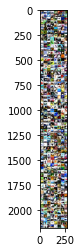

In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [18]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images) 

/content/models/CustomResNet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [20]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    get_test_accuracy(model, testloader, device)))

/content/models/CustomResNet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of the network on the 10000 test images: 90.51 %




The accuracy 89.98 is far better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [21]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/content/models/CustomResNet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 85 %
Accuracy of   cat : 66 %
Accuracy of  deer : 100 %
Accuracy of   dog : 66 %
Accuracy of  frog : 63 %
Accuracy of horse : 83 %
Accuracy of  ship : 83 %
Accuracy of truck : 100 %


## Plot the performance metrics

In this step, the following metrics are plotted

i. Training Accuracy
ii. Test Accuracy

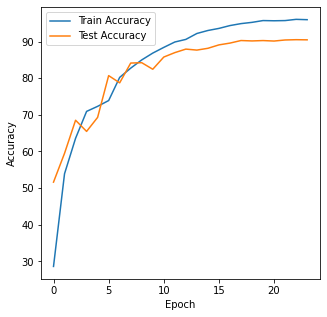

In [22]:
plot_accuracy(train_acc, test_acc)


## Display Misclassified Images

/content/models/CustomResNet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range fo

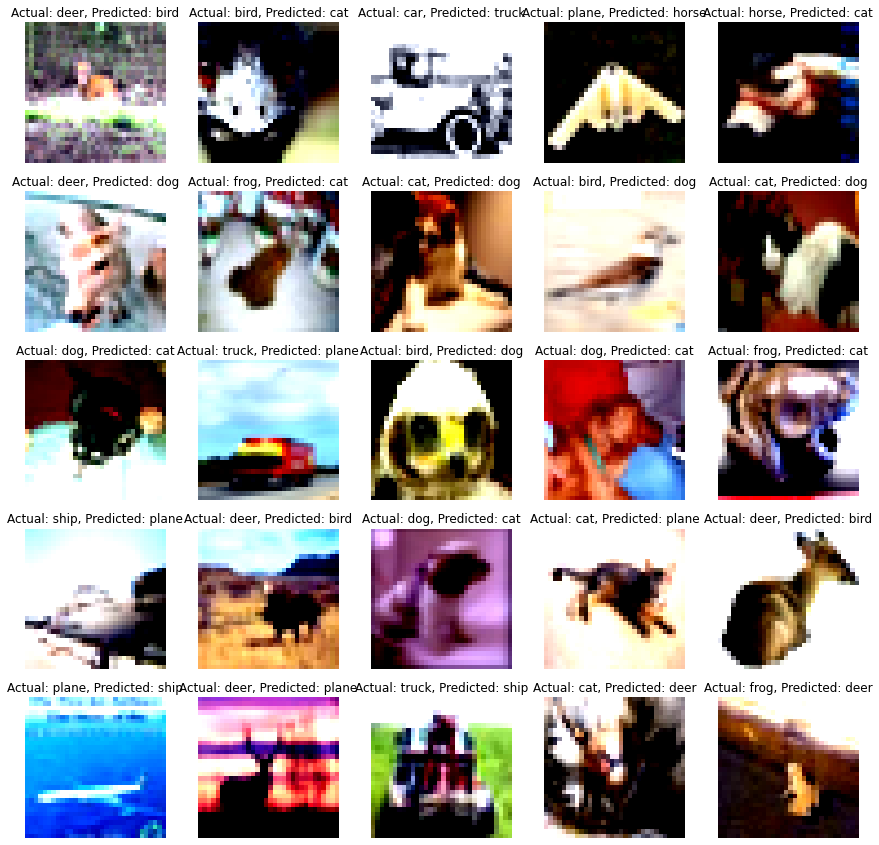

In [23]:
incorrect_images_list,predicted_label_list,correct_label_list=display_misclassfied_ciphar10_images(testloader, model, device, classes, 25)

In [24]:
incorrect_images=process_for_grad_cam(incorrect_images_list,predicted_label_list,correct_label_list,transform_test)

##Display GRADCAM for Misclassified Images

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/content/models/CustomResNet.py:76: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imsho

torch.Size([25, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
25


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


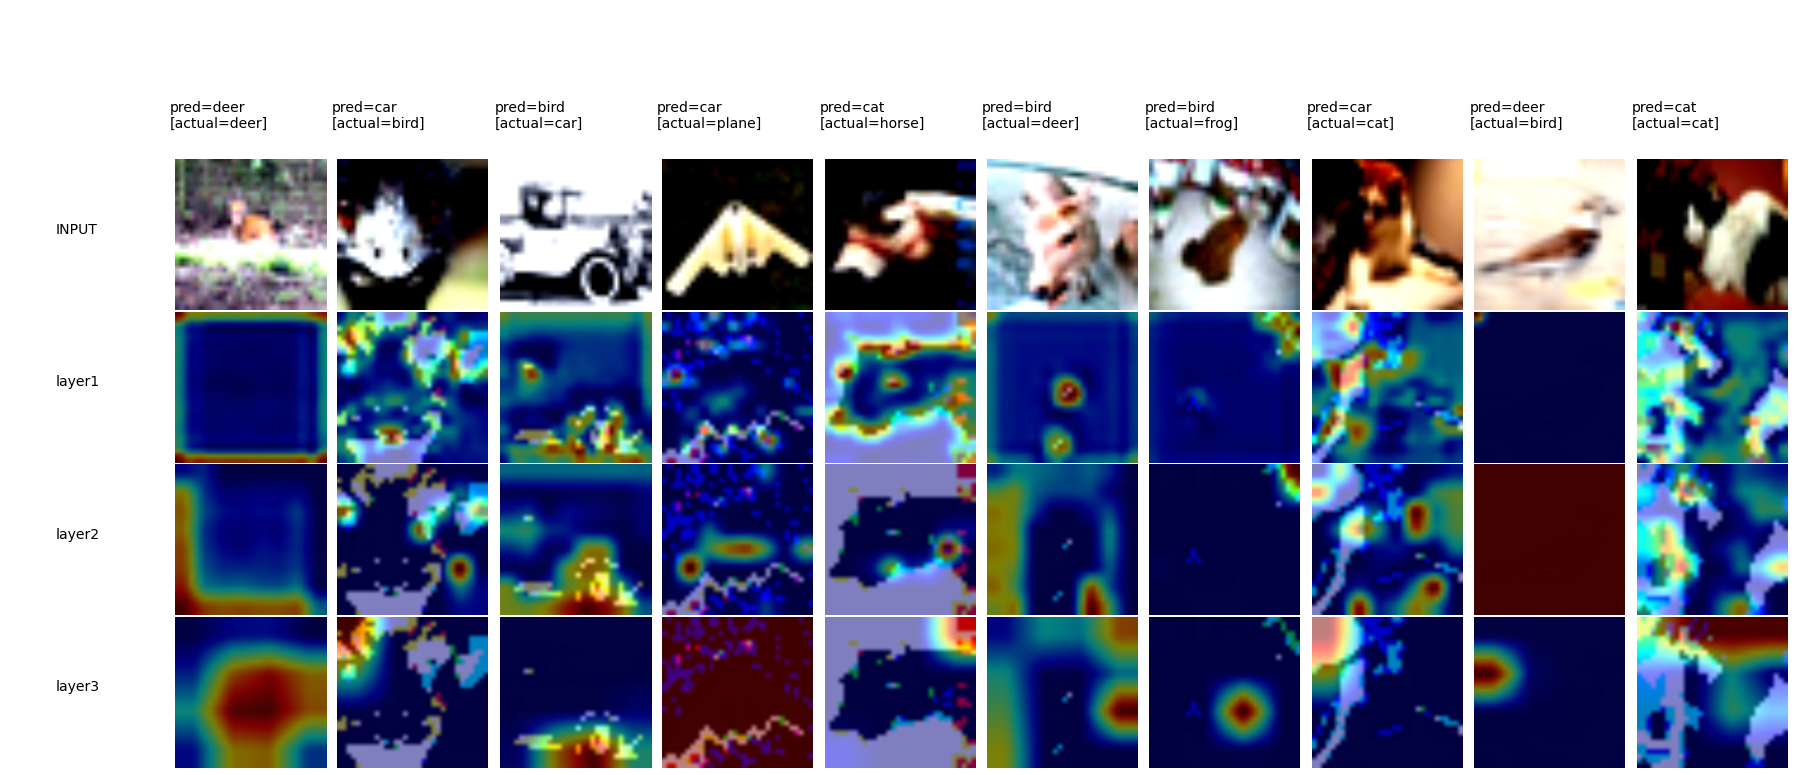

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

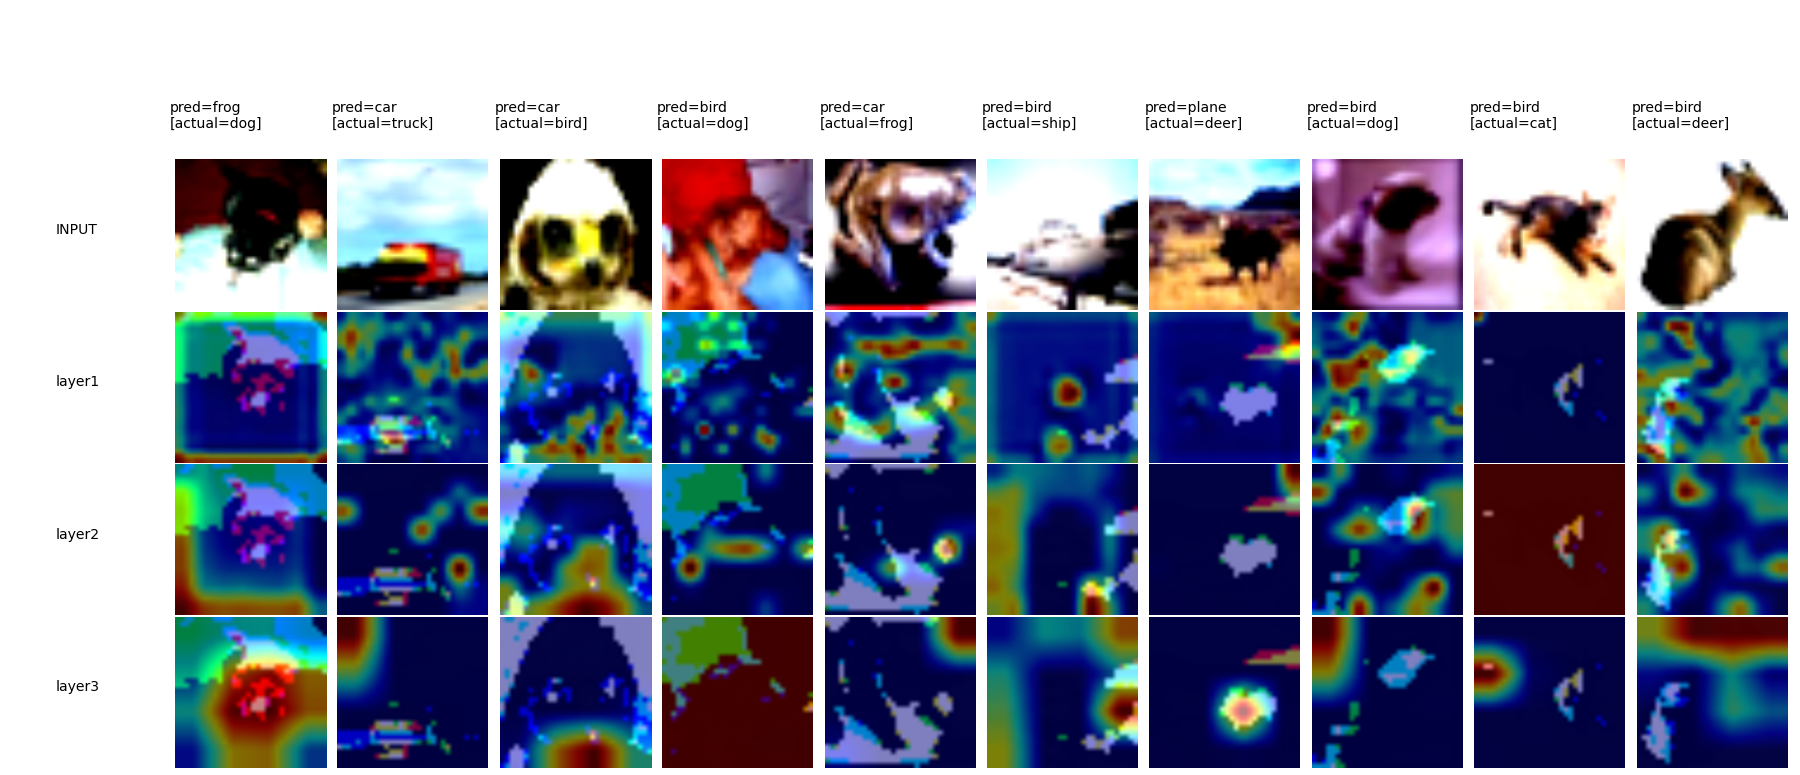

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


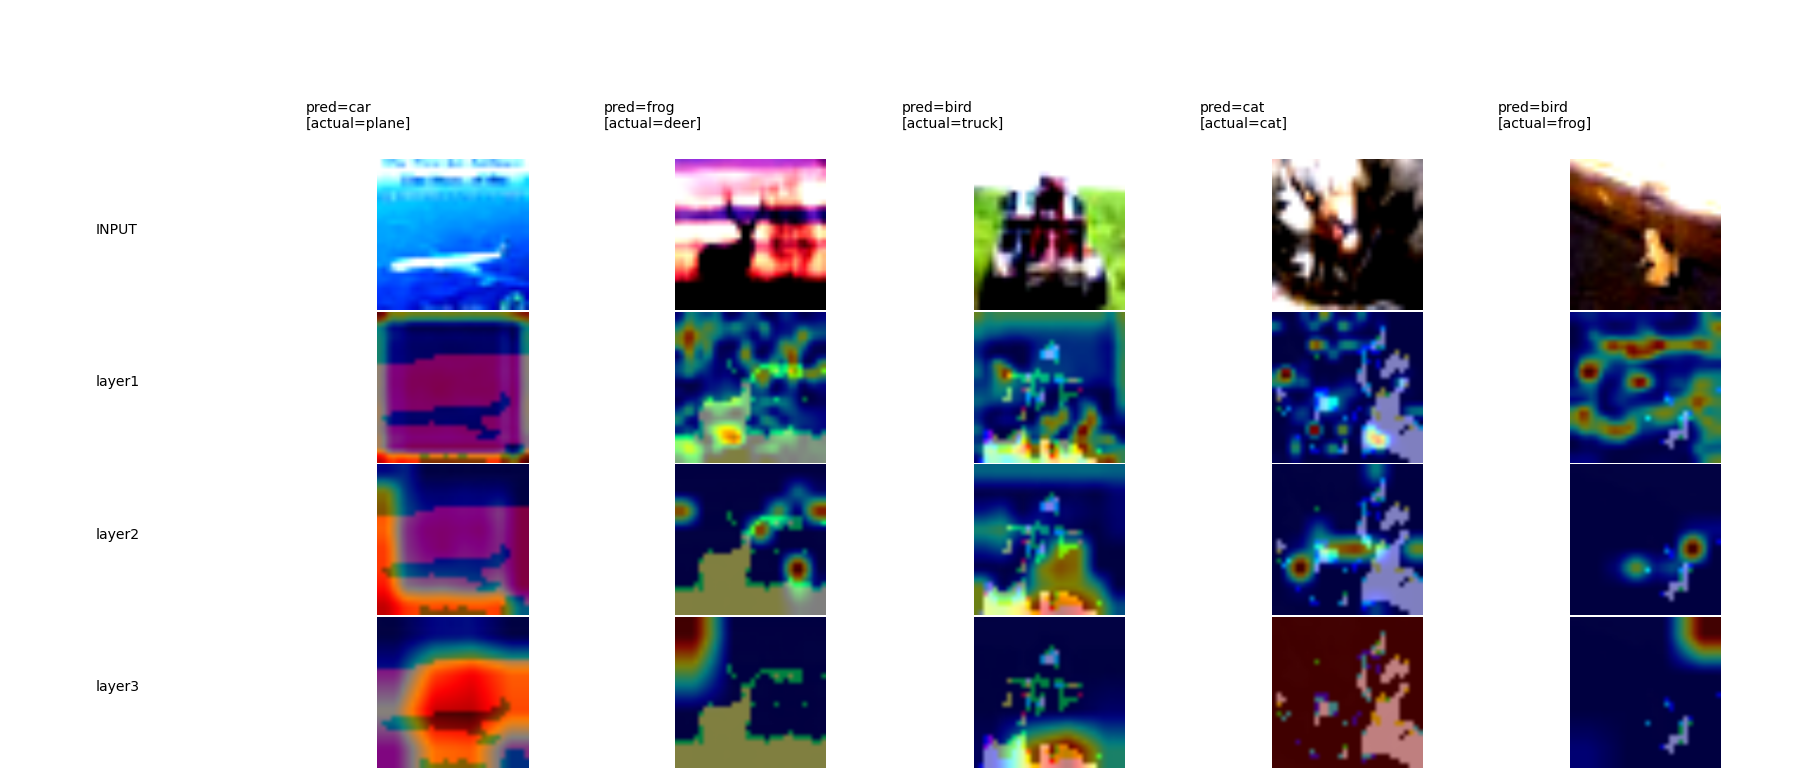

In [25]:
target_layers = ["layer1", "layer2", "layer3"]
gradcam_output, probs, predicted_classes = GRADCAM(incorrect_images, correct_label_list[0:25], model, target_layers)
print(len(predicted_classes))
PLOTGRADCAM(gradcam_output, incorrect_images_list[0:25],incorrect_images ,correct_label_list[0:25], target_layers, classes, (3, 32, 32), predicted_classes)
